In [1]:
import numpy as np
import pandas as pd

In [2]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 200)

### Utility Function

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

### Importing Preprocessed Data

In [4]:
df = pd.read_csv('../Data/Cleansed_Data.csv')
df = df.drop('Sum_delta', axis=1)
df.head()

,Events,Favourite,Underdog,Label,REACH_delta,SLPM_delta,SAPM_delta,STRA_delta,STRD_delta,TD_delta,TDA_delta,TDD_delta,SUBA_delta,Odds_delta
0,UFC 159 - Jones vs. Sonnen,Jon Jones,Chael Sonnen,Favourite,10,1.17,0.90,0.12,0.03,-1.56,-0.07,0.28,0.2,-7.87
1,UFC 159 - Jones vs. Sonnen,Leonard Garcia,Cody McKenzie,Underdog,-3,1.03,2.29,-0.10,-0.15,-2.20,0.01,0.28,-2.0,1.40
2,UFC Fight Night 34 - Saffiedine vs. Lim,Mairbek Taisumov,Tae Hyun Bang,Favourite,2,0.54,0.08,0.05,-0.05,1.75,0.44,0.28,-0.5,-2.89
3,UFC Fight Night 91 - McDonald vs. Lineker,Cody Pfister,Scott Holtzman,Underdog,4,-3.15,-0.85,-0.24,-0.06,0.55,-0.27,-0.58,-0.4,6.89
4,UFC Fight Night 91 - McDonald vs. Lineker,Matthew Lopez,Rani Yahya,Underdog,2,0.02,0.86,0.13,-0.06,-0.08,0.51,0.37,-0.5,0.81


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, classification_report, make_scorer, accuracy_score

#### Brief Insights

In [6]:
df.shape

(1315, 14)

In [7]:
df.dtypes

Events          object
Favourite       object
Underdog        object
Label           object
REACH_delta      int64
SLPM_delta     float64
SAPM_delta     float64
STRA_delta     float64
STRD_delta     float64
TD_delta       float64
TDA_delta      float64
TDD_delta      float64
SUBA_delta     float64
Odds_delta     float64
dtype: object

In [8]:
df.isna().sum()

Events         0
Favourite      0
Underdog       0
Label          0
REACH_delta    0
SLPM_delta     0
SAPM_delta     0
STRA_delta     0
STRD_delta     0
TD_delta       0
TDA_delta      0
TDD_delta      0
SUBA_delta     0
Odds_delta     0
dtype: int64

In [9]:
df['Label'].value_counts()/df.shape[0]

Favourite    0.627376
Underdog     0.372624
Name: Label, dtype: float64

<AxesSubplot:>

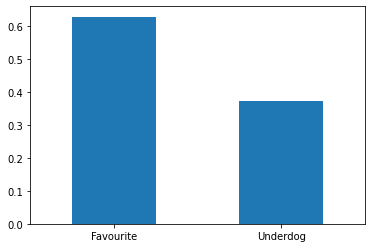

In [10]:
(df['Label'].value_counts()/df.shape[0]).plot(kind='bar', rot=0)

Encoding the target variable

In [11]:
df['Label'] = df['Label'].map(lambda x: 0 if x == 'Underdog' else 1)

# Feature Selection

* simplification of models to make them easier to interpret
* shorter training times (applicable to very huge datasets)
* to avoid the curse of dimensionality 
* enhanced generalization by reducing overfitting (reduction of variance)

From RFECV and Feature Importance as validation, we know:
* The 6 most important features are **'SLPM_delta', 'SAPM_delta', 'STRD_delta', 'TDD_delta', 'SUBA_delta', 'Odds_delta'**

In [12]:
def select_features(df):
    all_X = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis=1)
    all_y = df['Label']
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf)
    selector.fit(all_X, all_y)
    best_columns = list(all_X.columns[selector.support_])
    print('Best Columns \n' + '-'*12 + '\n' + '{}'.format(best_columns))
    
    return best_columns

## Recursive Feature Elimination with Cross Validation (RFECV)

The features will be selected based on Recursive Feature Elimination with Cross Validation [**(RFECV)**](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html). Recursive Feature Elimination (RFE) works by training the model, evaluating it, then removing the least significant features, and repeating.

In [13]:
best_cols = select_features(df)

Best Columns 
------------
['SLPM_delta', 'SAPM_delta', 'STRD_delta', 'TDD_delta', 'SUBA_delta', 'Odds_delta']


## Feature Importance

* Not suprising **Reach_delta** is of least importance since reach does not really determine a clear winner

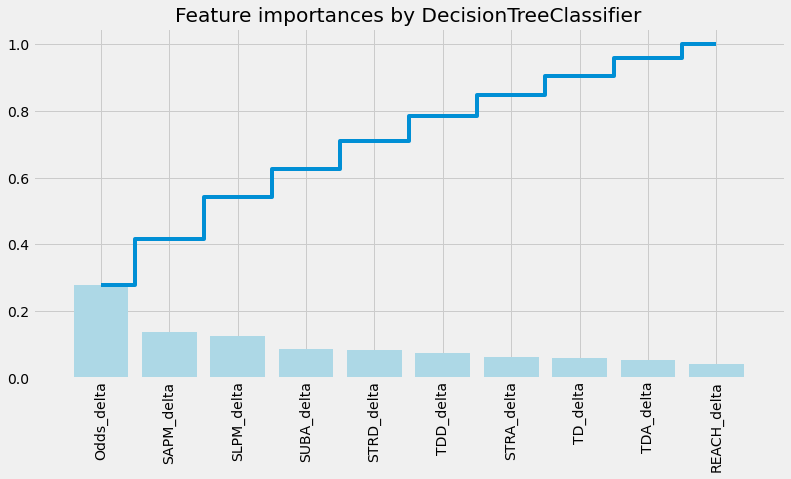

In [14]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

# Create train and test splits
target_name = 'Label'
X = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis=1)


y=df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=1, stratify=y)

dtree = RandomForestClassifier(
    #max_depth=3,
    random_state = 1,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

# Model Selection and Hyperparameter Tuning

* Model selection and hyperparameter tuning were accomplish using GridSearchCV
* There is no need to apply **train_test_split** in this case due to the Cross Validation embedded in GridSearchCV
* Among the models considered are: 
    * Logistic Regression
    * Decision Tree Classifier
    * KNeighbors Classifier
    * Random Forest Classifier
    * Neural Network (MLP)

In [64]:
def select_model(df, features):
    
    all_X = df[features]
    all_y = df["Label"]
    #create a list of dics which contains models and hyperparameters
    models = [
        
        {
            "name": "Logistic Regression",
            "estimator": LogisticRegression(),
            "hyperparameters":
            {
             "solver": ["newton-cg", "lbfgs", "liblinear"]   
            }
            
        },{
            "name": "Decision Tree Classifier",
            "estimator": DecisionTreeClassifier(),
            "hyperparameters":
            {   
            }
            
        },{
            "name": "Nearest Neighbor",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
            {
                "leaf_size": list(range(1,50)),
                "n_neighbors": list(range(1,30)),
                "p": [1,2]
            }
            
        },

        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        },
                {
            "name": "Multi Layer Perceptron (MLP)",
            "estimator": MLPClassifier(random_state=1),
            "hyperparameters":
                {
                    "hidden_layer_sizes": [(5,5), (10,10)],
                    "activation": ["relu", "tanh", "logistic"],
                    "solver": ['sgd', 'adam'],
                    "learning_rate": ["constant", "adaptive"]

                }
        }   
        
    ]
    
    for model in log_progress(models):
        print(model["name"])
        print("-"*len(model["name"]))
        
        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10, scoring = 'accuracy')
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        model["scoring"] = grid.scorer_
        
        print("Best Paramerters:\n" + "{}".format(model["best_params"]))
        print("Best Score:\n" + "{}".format(model["best_score"]))
        print("Best Model:\n" + "{}\n".format(model["best_model"]))
        print("Scoring method:\n" + "{}\n".format(model["scoring"]))
        
    return models

In [16]:
models = select_model(df, best_cols)

Logistic Regression
-------------------
Best Paramerters:
{'solver': 'newton-cg'}
Best Score:
0.7010929909784871
Best Model:
LogisticRegression(solver='newton-cg')

Scoring method:
make_scorer(accuracy_score)

Decision Tree Classifier
------------------------
Best Paramerters:
{}
Best Score:
0.6023305574832294
Best Model:
DecisionTreeClassifier()

Scoring method:
make_scorer(accuracy_score)

Nearest Neighbor
----------------
Best Paramerters:
{}
Best Score:
0.6737508674531576
Best Model:
KNeighborsClassifier()

Scoring method:
make_scorer(accuracy_score)

RandomForestClassifier
----------------------
Best Paramerters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 9}
Best Score:
0.7056789266712931
Best Model:
RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_leaf=8, n_estimators=9, random_state=1)

Scoring method:
make_scorer(accuracy_score)


c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Best Paramerters:
{'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'adam'}
Best Score:
0.7117337497108489
Best Model:
MLPClassifier(hidden_layer_sizes=(10, 10), random_state=1)

Scoring method:
make_scorer(accuracy_score)



c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Conclusion

* The final model selected, Neural Network (MLP) to predict winners from Favourite and Underdog has an **accuracy of ~71.17%**


# Testing

* We can finally test if our model does what it claims


In [17]:
y = df['Label']
X = df[best_cols]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [19]:
mlp = MLPClassifier(hidden_layer_sizes=(5, 5), random_state=1, activation='relu', learning_rate='constant', solver='adam')

mlp.fit(X_train, y_train)

pred = mlp.predict(X_test)

print(f'Accuracy of MLP clf is {accuracy_score(pred, y_test)}')

Accuracy of MLP clf is 0.6958174904942965


c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Building and saving final Model

* The final model selected, Neural Network (MLP) to predict winners from Favourite and Underdog has an **accuracy of ~70.8%**
* We also tested our model with a **20%** test size and ended up with an **accuracy of 74.52%**
* We can now build our model on all datasets and save the model as a pickle file to ease our access to the model in production



In [20]:
import pickle

In [21]:
mlp = MLPClassifier(hidden_layer_sizes=(5, 5), random_state=1, activation='relu', learning_rate='constant', solver='adam')

mlp.fit(X, y)

c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(5, 5), random_state=1)

In [23]:
with open('../Models/predict_winner.pkl','wb') as file:
    pickle.dump(mlp,file)

# Part ii

### Predicting how to win

In [26]:
df2 = pd.read_csv('../Data/prediction_data.csv', index_col="Unnamed: 0")
df2.head()

,fighter1,fighter2,winner,weight_class,title_fight,method,end_round,figth_year,attended,fight_coutry,win_fighter1,lose_fighter1,draw_fighter1,nc_fighter1,height_fighter1,reach_fighter1,stance_fighter1,SLpM_fighter1,Str_Acc_fighter1,SApM_fighter1,Str_Def_fighter1,TD_Avg_fighter1,TD_Acc_fighter1,TD_Def_fighter1,Sub_Avg_fighter1,win%_fighter1,born_year_fighter1,win_fighter2,lose_fighter2,draw_fighter2,nc_fighter2,height_fighter2,reach_fighter2,stance_fighter2,SLpM_fighter2,Str_Acc_fighter2,SApM_fighter2,Str_Def_fighter2,TD_Avg_fighter2,TD_Acc_fighter2,TD_Def_fighter2,Sub_Avg_fighter2,win%_fighter2,born_year_fighter2
0,Santiago Ponzinibbio,Neil Magny,1,Welterweight,f,KO/TKO,4,2018,10245.0,Argentina,28,3,0,0,"6' 0""","73""",Orthodox,4.27,39.0,4.02,64.0,0.54,44.0,60.0,0.0,90.322580,1986,21,8,0,0,"6' 3""","80""",Orthodox,3.86,46.0,2.22,56.0,2.62,46.0,60.0,0.3,72.413795,1987
1,Darren Elkins,Ricardo Lamas,0,Featherweight,f,KO/TKO,3,2018,10245.0,Argentina,25,7,0,0,"5' 10""","71""",Orthodox,3.36,37.0,2.83,53.0,2.68,35.0,57.0,1.3,78.125000,1984,19,7,0,0,"5' 8""","71""",Orthodox,2.87,45.0,2.61,59.0,1.66,32.0,47.0,1.0,73.076920,1982
2,Johnny Walker,Khalil Rountree Jr.,1,Light Heavyweight,f,KO/TKO,1,2018,10245.0,Argentina,15,3,0,0,"6' 5""","82""",Orthodox,5.37,70.0,3.36,25.0,0.89,100.0,100.0,2.6,83.333336,1992,8,2,0,2,"6' 1""","76""",Southpaw,2.30,34.0,3.29,38.0,0.00,0.0,50.0,0.3,66.666664,1990
3,Cezar Ferreira,Ian Heinisch,0,Middleweight,f,DEC,3,2018,10245.0,Argentina,14,7,0,0,"6' 1""","78""",Southpaw,1.83,42.0,2.14,55.0,2.97,59.0,90.0,0.5,66.666664,1985,12,1,0,0,"5' 11""",NaN,Orthodox,3.49,58.0,1.67,52.0,0.81,14.0,50.0,1.6,92.307690,1988
4,Marlon Vera,Guido Cannetti,1,Bantamweight,f,SUB,2,2018,10245.0,Argentina,12,5,1,0,"5' 8""","70""",Switch,3.23,44.0,3.93,52.0,0.78,37.0,68.0,1.3,66.666664,1992,8,5,0,0,"5' 6""","68""",Southpaw,2.80,52.0,1.95,51.0,2.80,50.0,75.0,0.3,61.538460,1979


In [27]:
use_cols = ['winner', 'weight_class', 'title_fight', 'method', 'end_round']
data_ = df2[use_cols]

In [28]:
data_['SLPM_delta'] = df2['SLpM_fighter1'] - df2['SLpM_fighter2']

<ipython-input-28-d70c40e61580>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_['SLPM_delta'] = df2['SLpM_fighter1'] - df2['SLpM_fighter2']


In [30]:
data_['SAPM_delta'] = df2['SApM_fighter1'] - df2['SApM_fighter2']
data_['STRD_delta'] = df2['Str_Def_fighter1'] - df2['Str_Def_fighter2']
data_['TDD_delta'] = df2['TD_Def_fighter1'] - df2['TD_Def_fighter2']
data_['SUBA_delta'] = df2['Sub_Avg_fighter1'] - df2['Sub_Avg_fighter2']

<ipython-input-30-11a649a53171>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_['SAPM_delta'] = df2['SApM_fighter1'] - df2['SApM_fighter2']
<ipython-input-30-11a649a53171>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_['STRD_delta'] = df2['Str_Def_fighter1'] - df2['Str_Def_fighter2']
<ipython-input-30-11a649a53171>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [35]:
data_['title_fight'] = data_.title_fight.map(lambda x: 0 if x == 'f' else 1)

<ipython-input-35-43147d388d53>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_['title_fight'] = data_.title_fight.map(lambda x: 0 if x == 'f' else 1)


In [37]:
data_.method.unique()

array(['KO/TKO', 'DEC', 'SUB', 'DQ'], dtype=object)

In [38]:
map_method = {
    'KO/TKO': 0,
    'DEC': 1,
    'SUB': 2,
    'DQ': 3
}

In [40]:
data_['method'] = data_.method.map(lambda x: map_method[x])

<ipython-input-40-ba2dd3d6a197>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_['method'] = data_.method.map(lambda x: map_method[x])


In [44]:
data_ = pd.get_dummies(data_)

In [45]:
data_.head()

,winner,title_fight,method,end_round,SLPM_delta,SAPM_delta,STRD_delta,TDD_delta,SUBA_delta,weight_class_Bantamweight,weight_class_Catch Weight,weight_class_Featherweight,weight_class_Flyweight,weight_class_Heavyweight,weight_class_Light Heavyweight,weight_class_Lightweight,weight_class_Middleweight,weight_class_Open Weight,weight_class_Super Heavyweight,weight_class_Welterweight,weight_class_Women's Bantamweight,weight_class_Women's Featherweight,weight_class_Women's Flyweight,weight_class_Women's Strawweight
0,1,0,0,4,0.41,1.80,8.0,0.0,-0.3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,3,0.49,0.22,-6.0,10.0,0.3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,3.07,0.07,-13.0,50.0,2.3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,3,-1.66,0.47,3.0,40.0,-1.1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,2,2,0.43,1.98,1.0,-7.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Will the fighter win by Knock Out or Other methods?

In [46]:
data_ko = data_.drop('end_round', axis=1)

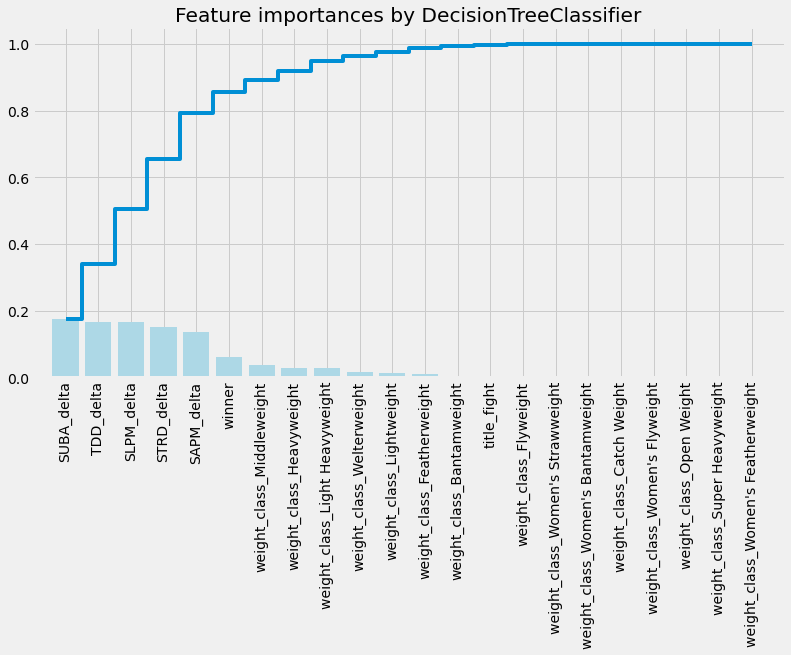

In [48]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

# Create train and test splits
target_name = 'method'
X = data_ko.drop(['method'], axis=1)


y=data_ko[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=1, stratify=y)

dtree = RandomForestClassifier(
    #max_depth=3,
    random_state = 1,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = data_ko.drop(['method'], axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [50]:
data_ko['Label'] = data_ko['method']
data_ko.drop('method', axis=1, inplace=True)

In [51]:
models2 = select_model(data_ko, data_ko.columns)

Logistic Regression
-------------------


c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Best Paramerters:
{'solver': 'newton-cg'}
Best Score:
0.9971687032300844
Best Model:
LogisticRegression(solver='newton-cg')

Scoring method:
make_scorer(accuracy_score)

Decision Tree Classifier
------------------------
Best Paramerters:
{}
Best Score:
1.0
Best Model:
DecisionTreeClassifier()

Scoring method:
make_scorer(accuracy_score)

Nearest Neighbor
----------------
Best Paramerters:
{}
Best Score:
0.5295192763095576
Best Model:
KNeighborsClassifier()

Scoring method:
make_scorer(accuracy_score)

RandomForestClassifier
----------------------
Best Paramerters:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}
Best Score:
0.9949928957090084
Best Model:
RandomForestClassifier(max_depth=10, max_features='log2', min_samples_split=5,
                       n_estimators=9, random_state=1)

Scoring method:
make_scorer(accuracy_score)

Multi Layer Perceptron (MLP)
----------------------------


c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Best Paramerters:
{'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'adam'}
Best Score:
0.9973865681538315
Best Model:
MLPClassifier(hidden_layer_sizes=(10, 10), random_state=1)

Scoring method:
make_scorer(accuracy_score)



In [57]:
X = data_ko.drop('Label', axis=1)
y = data_ko['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

rf = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_split=5,n_estimators=9, random_state=1)

rf.fit(X_train, y_train)

pred = rf.predict(X_test)

print(f'Accuracy of RF clf is {accuracy_score(pred, y_test)}')

Accuracy of RF clf is 0.5038084874863983


In [58]:
with open('../Models/predict_method.pkl','wb') as file:
    pickle.dump(rf,file)

### Predicting End Round

In [60]:
data_['Label'] = data_['end_round']
data_.drop('end_round', axis=1, inplace=True)

In [65]:
models3 = select_model(data_, data_.columns)

Logistic Regression
-------------------


c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Best Paramerters:
{'solver': 'newton-cg'}
Best Score:
0.9956436487638534
Best Model:
LogisticRegression(solver='newton-cg')

Scoring method:
make_scorer(accuracy_score)

Decision Tree Classifier
------------------------
Best Paramerters:
{}
Best Score:
1.0
Best Model:
DecisionTreeClassifier()

Scoring method:
make_scorer(accuracy_score)

Nearest Neighbor
----------------


KeyboardInterrupt: 

In [67]:
X = data_.drop('Label', axis=1)
y = data_['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

rf = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_split=5,n_estimators=9, random_state=1)

rf.fit(X_train, y_train)

pred = rf.predict(X_test)

print(f'Accuracy of RF clf is {accuracy_score(pred, y_test)} \n {classification_report(pred, y_test)}')

Accuracy of RF clf is 0.6844396082698585 
               precision    recall  f1-score   support

           1       0.82      0.55      0.66       392
           2       0.04      0.26      0.07        23
           3       0.87      0.82      0.84       491
           4       0.00      0.00      0.00         0
           5       0.11      0.23      0.15        13

    accuracy                           0.68       919
   macro avg       0.37      0.37      0.34       919
weighted avg       0.82      0.68      0.74       919



c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\maliex\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [68]:
with open('../Models/predict_end_round.pkl','wb') as file:
    pickle.dump(rf,file)

In [76]:
df2.weight_class.unique()

array(['Welterweight', 'Featherweight', 'Light Heavyweight',
       'Middleweight', 'Bantamweight', "Women's Strawweight", 'Flyweight',
       'Lightweight', 'Heavyweight', "Women's Bantamweight",
       "Women's Featherweight", 'Catch Weight', "Women's Flyweight",
       'Open Weight', 'Super Heavyweight'], dtype=object)

In [80]:
n = np.array([1,2,3,4])
m = np.array([2,4,6,8,0])

In [86]:
j = np.array(n+m)

In [89]:
j.reshape(1,9)

array([[1, 2, 3, 4, 2, 4, 6, 8, 0]])